In [3]:
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = "imagenet"

In [ ]:
from segmentation_models_pytorch import Unet

def get_unet_model(num_classes=1):
    return Unet(
        encoder_name=ENCODER_NAME,  # Same encoder as in training
        encoder_weights=ENCODER_WEIGHTS,  # Use pretrained encoder weights
        in_channels=3,
        classes=num_classes,  # Number of output classes
    )

get_unet_model(1)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [38]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class HaulRoadInference:
    def __init__(self, model_path, device="cuda"):
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        
        # Load the trained model
        self.model = self.load_model(model_path)
        self.model.eval()  # Set model to evaluation mode

        # Define preprocessing pipeline
        self.transform = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

    def load_model(self, model_path):
        # Replace `UNet` with your model architecture if necessary
        # from torchvision.models.segmentation import fcn_resnet50
        # Define the model architecture
        model = get_unet_model(num_classes=1)  # Ensure this matches your training setup

        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Load state dict
        if "state_dict" in checkpoint:
            state_dict = checkpoint["state_dict"]
            
            # Inspect the state_dict for debugging
            for key, value in state_dict.items():
                if not isinstance(value, torch.Tensor):
                    raise TypeError(f"Unexpected value type for key '{key}': {type(value)}")

            # Remove 'model.' prefix from keys
            new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
            model.load_state_dict(new_state_dict, strict=False)
        else:
            model.load_state_dict(checkpoint)

        return model.to(self.device)

    def preprocess(self, image_path):
        # Load image and apply transformations
        image = np.array(Image.open(image_path).convert("RGB"))
        augmented = self.transform(image=image)
        tensor_image = augmented["image"].unsqueeze(0)  # Add batch dimension
        return tensor_image.to(self.device)

    def postprocess(self, logits):
        # Apply sigmoid to logits and threshold
        probs = torch.sigmoid(logits)
        binary_mask = (probs > 0.5).float()  # Binary threshold
        
        image_tensor = binary_mask.squeeze(0).permute(1, 2, 0)  # Shape: (256, 256, 3)

        # Convert the tensor to a NumPy array for visualization
        image_np = image_tensor.cpu().numpy()

        # Clip normalization to range [0, 1] if necessary
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        return image_np  # Remove batch dimension

    def infer(self, image_path):
        # Preprocess image
        input_tensor = self.preprocess(image_path)
        
        # Forward pass
        with torch.no_grad():
            print(input_tensor)
            logits = self.model(input_tensor)  # Adjust key if different
        
        # Postprocess logits to binary mask
        mask = self.postprocess(logits)
        return mask

    def visualize(self, image_path, mask):
        # Load original image
        original_image = np.array(Image.open(image_path))
        
        # Overlay mask on original image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        
        
        plt.imshow(mask, cmap="gray")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


/tmp/ipykernel_304755/31123567.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.device)


tensor([[[[ 0.0569,  0.1597,  0.3138,  ..., -0.4568, -0.2856, -0.3198],
          [ 0.1254,  0.1768,  0.3481,  ..., -0.3369, -0.3541, -0.3369],
          [ 0.2282,  0.1768,  0.1083,  ..., -0.3541, -0.3541, -0.3883],
          ...,
          [-0.4397, -0.3027,  0.3481,  ..., -0.6281, -0.1657,  0.0912],
          [ 0.4337,  0.3138,  0.0056,  ..., -0.1143, -0.7993, -0.0458],
          [ 0.0912,  0.0398,  0.0398,  ..., -0.4911, -0.6623, -0.3198]],

         [[-0.3550, -0.2325, -0.1275,  ..., -1.0553, -0.9853, -0.9853],
          [-0.2500, -0.2150, -0.1099,  ..., -0.9678, -1.0378, -0.9678],
          [-0.2675, -0.2850, -0.3375,  ..., -0.9853, -0.9853, -1.0203],
          ...,
          [-0.4251, -0.3725,  0.0651,  ..., -0.5651, -0.3725, -0.3550],
          [ 0.1877,  0.1527, -0.2675,  ..., -0.2675, -0.9853, -0.4601],
          [ 0.0651, -0.1625, -0.1099,  ..., -0.5826, -0.8452, -0.6352]],

         [[-0.6367, -0.6367, -0.4798,  ..., -1.1421, -1.0724, -1.1247],
          [-0.5844, -0.5844, -

/tmp/ipykernel_304755/31123567.py:67: RuntimeWarning: invalid value encountered in divide
  image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())


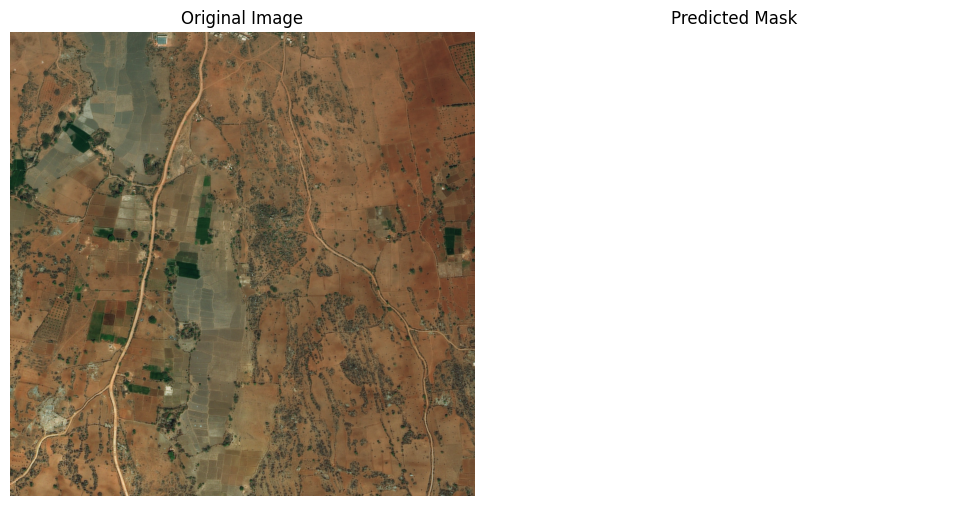

In [43]:
# Paths
model_path = "lightning_logs/version_11/checkpoints/epoch=2-step=123.ckpt"
image_path = "data/splitted/deepglobe-2018-dataset/train/images/33573.jpg"

# Initialize inference pipeline
inference_pipeline = HaulRoadInference(model_path)

# Perform inference
predicted_mask = inference_pipeline.infer(image_path)
# image_np = predicted_mask.squeeze(0).permute(1, 2, 0).cpu().numpy()
# image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Visualize results
inference_pipeline.visualize(image_path, predicted_mask)
